Generate augmented tidal structure

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os
import cv2

import random
from copy import deepcopy

Specify the file path for annotation (Note: the annotation that will be used in the following section come from "basichalosnocompanions_splittidal", which completely separate elongated tidal if the mask of object are not connected)

In [10]:
# file_path = "../datasets/matlas_images_and_annotations/"
file_path = "H:/My Drive/panoptic/datasets/matlas_images_and_annotations/"
# Noted the destination path need to point to the folder that contain elongated strucuture that already splitted
annotation_file_path = file_path + "annotations/standard/double/basichalosnocompanions_splittidal/"

# structure_name = {}
mask_files_name = {}

# structure_name["Elongated tidal structures"] = "Elongated tidal structures"
mask_files_name["Elongated tidal structures"] = glob.glob(annotation_file_path + "*" + "Elongated tidal structures.npz")

# get the label file that has tidal structures then link to npy file
image_files_name = ["=".join(os.path.split(structure_file)[-1].split('=')[:2])[:-6] + ".npy" for structure_file in mask_files_name["Elongated tidal structures"]]

for structure_name in ["Diffuse halo", "Galaxy"]:
    mask_files_name[structure_name] = [annotation_file_path + "=".join(os.path.split(structure_file)[-1].split('=')[:2] + [structure_name]) + ".npz" for structure_file in mask_files_name["Elongated tidal structures"]]

In [11]:
mask_files_name

{'Elongated tidal structures': ['H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_splittidal\\name=NGC3226-class=Elongated tidal structures.npz',
  'H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_splittidal\\name=UGC08693-class=Elongated tidal structures.npz',
  'H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_splittidal\\name=NGC5638-class=Elongated tidal structures.npz',
  'H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_splittidal\\name=NGC7463-class=Elongated tidal structures.npz',
  'H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_splittidal\\name=NGC7465-class=Elongated tidal structures.npz',
  'H:/My Drive/panoptic/datasets/matlas_images_and_annotations/annotations/stan

In [12]:
from scipy import ndimage

def decode_np_mask(array):
    shape, mask, centre = array['shape'], array['mask'], array['centre']
    mask = np.unpackbits(mask)
    mask = mask[:np.prod(shape)]
    
    return mask.reshape(shape), centre

def getMask(mask_files_name):
    mask_path = mask_files_name

    mask = decode_np_mask(np.load(mask_path, allow_pickle=True))[0]
    mask = mask[np.count_nonzero(mask, axis=(1, 2)) > 0]
    return mask
    
def encode_np_mask(mask, file_name):
    shape = mask.shape
    mask = np.packbits(mask)
    np.savez(file_name, shape=shape, mask=mask, centre=None)

def inverseQuadratic(x, eps=0.2):
    return 1.0/(1+(eps*x)**2)


def augmentElongMask(masks, galaxy_cm, mesh_x, mesh_y, alpha=10):
    mesh_x = mesh_x.astype("float64")
    mesh_y = mesh_y.astype("float64")

    binary_mask = masks.astype(np.uint8)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    unit_vec = np.random.rand(2)-0.5
    # unit_vec = np.array([1,0])
    unit_vec = unit_vec/np.linalg.norm(unit_vec)

    rbf_field = np.zeros_like(masks,dtype="float64")
    stretch_mask_field = np.zeros_like(masks)


    galaxy_idx = np.argwhere(masks == 1)
    k = np.linalg.norm(galaxy_idx - galaxy_cm, axis=1)
    galaxy_cm = galaxy_idx[np.argmin(k)][::-1]
    
    for y in range(binary_mask.shape[0]):
        for x in range(binary_mask.shape[1]):
            in_contour = cv2.pointPolygonTest(contours[0], [x,y], measureDist=False)
            norm = np.linalg.norm(contours[0][:,0,:] - np.array([x,y]), axis=1)
            min_idx = np.argmin(norm)
            dist = np.min(norm)

            # distance to galaxy cm
            if in_contour < 0:
                # if in contour < 0 then the value is outside of mask 
                rbf_field[y,x] = inverseQuadratic(dist)
                # if the point is outside of mask then limit value to the maximum
                min_idx = np.argmin(norm)
                stretch_mask_field[y,x] = np.linalg.norm(contours[0][min_idx,0,:] - galaxy_cm)
            else:
                rbf_field[y,x] = 1
                stretch_mask_field[y,x] = np.min(np.linalg.norm(np.array([x,y]) - galaxy_cm))
    
    plt.imshow(rbf_field)
    plt.show()
    plt.imshow(stretch_mask_field)
    plt.show()

    stretch_mask_field = stretch_mask_field/np.max(stretch_mask_field)

    mesh_x += alpha*stretch_mask_field*rbf_field*unit_vec[0]
    mesh_y += alpha*stretch_mask_field*rbf_field*unit_vec[1]

    return masks, mesh_x, mesh_y

Test image deformation algorithm using simple mesh grid

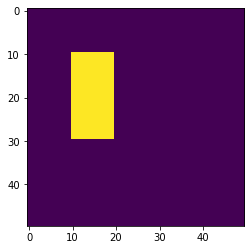

(19.5, 14.5)


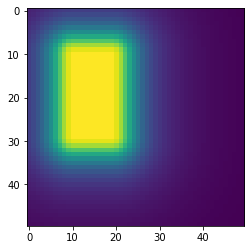

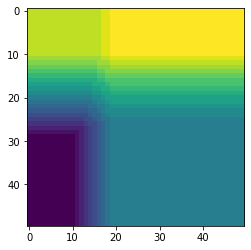

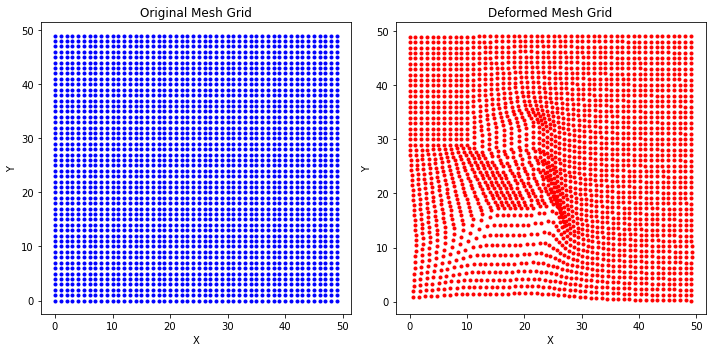

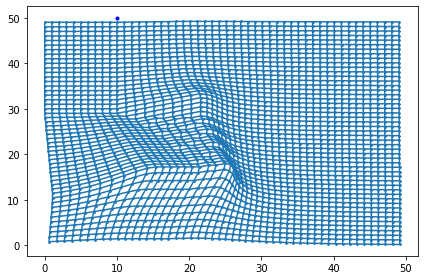

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import ndimage


# Create a mesh grid
x = np.arange(0, 50)  # x-coordinates
y = np.arange(0, 50)  # y-coordinates
X, Y = np.meshgrid(x, y)     # Create mesh grid

mask = np.zeros_like(X)
mask[10:30,10:20] = 1

plt.imshow(mask)
plt.show()

galaxy_cm = np.array([[50, 10]])
elongated_cm = ndimage.center_of_mass(mask)

print(elongated_cm)

alpha = 10
beta = 5
elong_idx = np.argwhere(mask == 1)

min_distance = mask
min_distance = np.linalg.norm(galaxy_cm)

# create random unit vector
unit_vec = np.random.rand(2)-0.5
unit_vec = unit_vec/np.linalg.norm(unit_vec)

# create unit vector
unit_vec = np.array([0,1])
unit_vec = unit_vec/np.linalg.norm(unit_vec)


mask, deformed_X, deformed_Y = augmentElongMask(mask, galaxy_cm, X, Y)

map_x = deformed_X.astype(np.float32)
map_y = deformed_Y.astype(np.float32)

# Plot the original and deformed mesh grids
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Original Mesh Grid')
axs[0].plot(X, Y, '.', color='b')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')


axs[1].set_title('Deformed Mesh Grid')
axs[1].plot(deformed_X, deformed_Y, '.', color='r')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()

plt.scatter(map_x, map_y, s=3)
segs1 = np.stack((map_x, map_y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.plot(galaxy_cm[0,1], galaxy_cm[0,0], '.', color='b')
plt.tight_layout()
plt.show()


In [14]:
def augmentMask(change_mask, unchange_masks, galaxy_cm, mesh_x, mesh_y, alpha=10, eps=0.05):
    """ Augmentation algorithm for single elongated mask.

    :change_mask: A list containing a masks of object that need to be deformed (ex. elongated structure)
    :unchange_masks: A list containing a masks of the rest of the objects (ex. galaxy core, etc.)
    :galaxy_cm: A center of mass of galaxy mask
    :mesh_x, mesh_y: mesh grid of the image
    :alpha: total deformation gain
    :eps: inverse quadratic gain

    :return: mesh_x, mesh_y: specify the mesh grid after deformation
    """
    
    mesh_x = mesh_x.astype("float64")
    mesh_y = mesh_y.astype("float64")

    binary_mask = change_mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    unit_vec = np.random.rand(2)-0.5
    unit_vec = unit_vec/np.linalg.norm(unit_vec)

    rbf_field = np.zeros_like(change_mask,dtype="float64")
    stretch_mask_field = np.zeros_like(change_mask)
    
    galaxy_idx = np.argwhere(change_mask == 1)
    k = np.linalg.norm(galaxy_idx - galaxy_cm, axis=1)
    galaxy_cm = galaxy_idx[np.argmin(k)][::-1]

    unchange_mask = np.zeros_like(change_mask)
    for key in unchange_masks:
        for i in range(unchange_masks[key].shape[0]):
            unchange_mask = cv2.bitwise_or(unchange_mask, unchange_masks[key][i,:,:])

    is_changable_field = cv2.bitwise_not(unchange_mask).astype(float) - 254.0
    
    for y in range(binary_mask.shape[0]):
        for x in range(binary_mask.shape[1]):
            in_contour = cv2.pointPolygonTest(contours[0], [x,y], measureDist=False)
            norm = np.linalg.norm(contours[0][:,0,:] - np.array([x,y]), axis=1)
            min_idx = np.argmin(norm)
            dist = np.min(norm)

            # distance to galaxy cm
            if in_contour < 0:
                # if in_contour < 0 then the value is outside of mask 
                rbf_field[y,x] = inverseQuadratic(dist, eps=eps)
                # if the point is outside of mask then limit value to the maximum
                min_idx = np.argmin(norm)
                stretch_mask_field[y,x] = np.linalg.norm(contours[0][min_idx,0,:] - galaxy_cm)
            else:
                # inside mask
                rbf_field[y,x] = 1
                stretch_mask_field[y,x] = np.min(np.linalg.norm(np.array([x,y]) - galaxy_cm))

    stretch_mask_field = stretch_mask_field/np.max(stretch_mask_field)
    
    mesh_x += alpha*rbf_field*stretch_mask_field*is_changable_field*unit_vec[0]
    mesh_y += alpha*rbf_field*stretch_mask_field*is_changable_field*unit_vec[1]

    return mesh_x, mesh_y

In [15]:
def minDistElongs2Objs(elong_masks, obj_masks):
    """ Minimum distance between elongated mask objects and specified masks

    calculate minimum distance from centroid of elongated masks objects to closest specified objects' centroid  

    :elong_mask: A list containing a masks of elongated structures
    :obj_masks: A list containing a masks of object that wanted to measure distances (ex. galaxy core)
    
    :return: min_idxs: A list containing the idx of closest object to elongated mask
    :return: min_dists: A list containing the distance of closest object to elongated mask
    """

    elong_cms = [ndimage.center_of_mass(mask) for mask in elong_masks]
    obj_cms = [ndimage.center_of_mass(mask) for mask in obj_masks]

    min_dists = []
    min_idxs = []
    for i, elong_cm in enumerate(elong_cms): 
        min_idx = np.argmin(np.linalg.norm(np.array(obj_cms) - elong_cm, axis=1))
        min_dist = np.min(np.linalg.norm(np.array(obj_cms) - elong_cm, axis=1))
        
        min_idxs.append(min_idx)
        min_dists.append(min_dist)

    return min_dists, min_idxs

def elongDeform(_image, _masks=None, amplitude=1, frequency=10):
    height, width = _image.shape[1:]
    # Create a mesh grid
    x = np.linspace(0, width - 1, width)  # x-coordinates
    y = np.linspace(0, height - 1, height)  # y-coordinates
    deformed_X, deformed_Y = np.meshgrid(x, y)  # Create mesh grid

    image = deepcopy(_image)
    masks = deepcopy(_masks)
    
    change_masks = masks["Elongated tidal structures"]
    unchange_masks = {}
    for key in ["Galaxy"]:
        if key in masks:
            unchange_masks[key] = masks[key]
    
    # i = 0
    # if i != None:
    for i in range(change_masks.shape[0]):
        min_dists, min_idxs = minDistElongs2Objs(change_masks, unchange_masks["Galaxy"])
        galaxy_cm = ndimage.center_of_mass(unchange_masks["Galaxy"][min_idxs[i]])
        deformed_X, deformed_Y = augmentMask(change_masks[i], unchange_masks, galaxy_cm, deformed_X, deformed_Y, alpha=125, eps=0.03)

    map_x = deformed_X.astype(np.float32)
    map_y = deformed_Y.astype(np.float32)
    
    augmented_image = cv2.remap(image.transpose(1,2,0), map_x, map_y, cv2.INTER_LINEAR).transpose(2,0,1)

    if masks is not None:
        augmented_masks = {}
        for key in masks.keys():
            # swap from [channel,x,y] to [row,col,channel]
            # masks[key] = masks[key].transpose(2,1,0)
            masks[key] = masks[key].transpose(1,2,0)
            
            if masks[key].shape[2] == 1:
                masks[key] = masks[key][:,:,0]

            # swap from [row,col,channel] to [channel,row,col]
            augmented_masks[key] = cv2.remap(masks[key], map_x, map_y, cv2.INTER_LINEAR)
            augmented_masks[key] = (augmented_masks[key] >= 0.5).astype(np.uint8)

            if len(masks[key].shape) == 2:
                augmented_masks[key] = augmented_masks[key][np.newaxis,:,:]
            else:
                augmented_masks[key] = augmented_masks[key].transpose(2,0,1)

    if masks is not None:
        return augmented_image, augmented_masks, map_x, map_y
    else:
        return augmented_image


['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

C:\Users\worac\AppData\Local\Temp\ipykernel_19356\169484590.py:44: RuntimeWarning: invalid value encountered in true_divide
  stretch_mask_field = stretch_mask_field/np.max(stretch_mask_field)


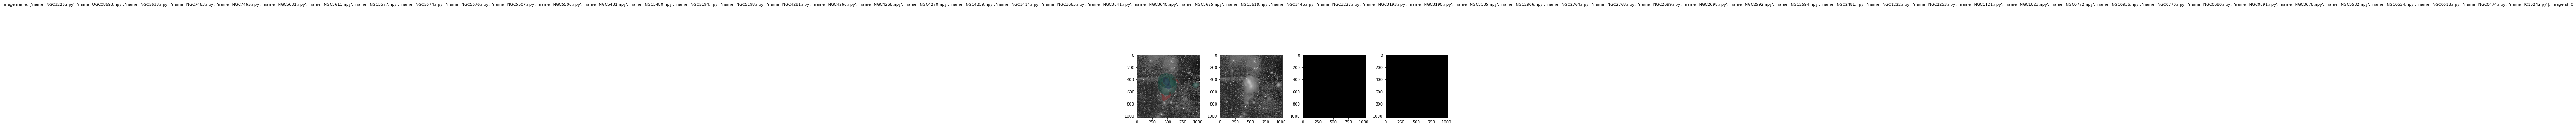

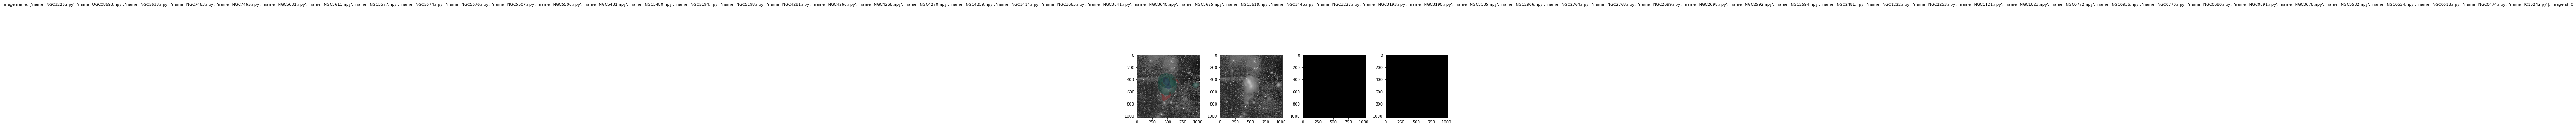

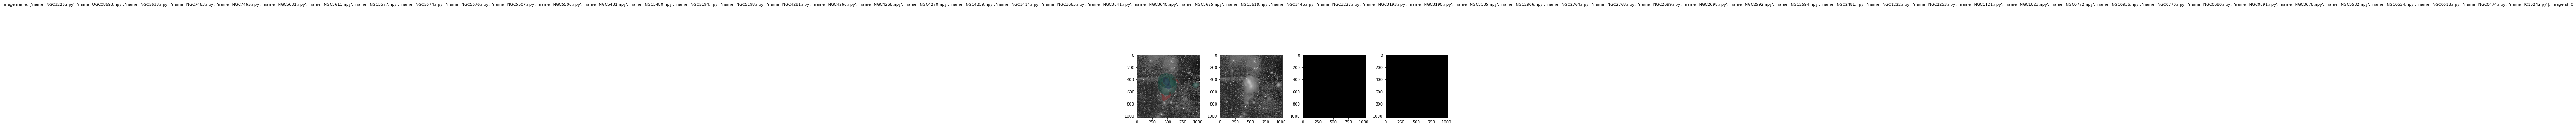

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

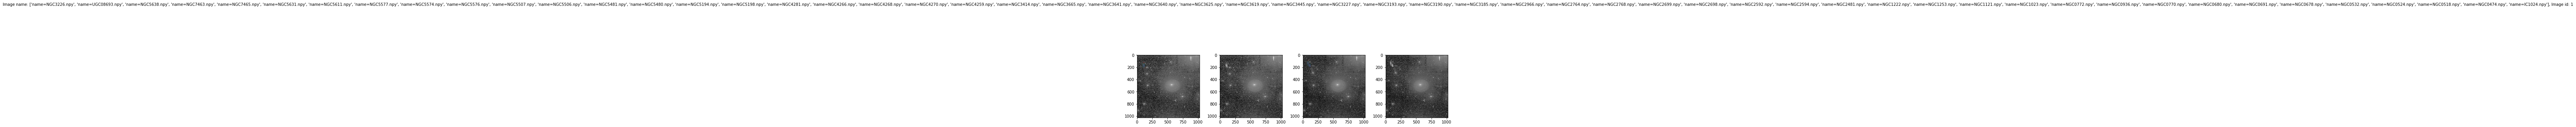

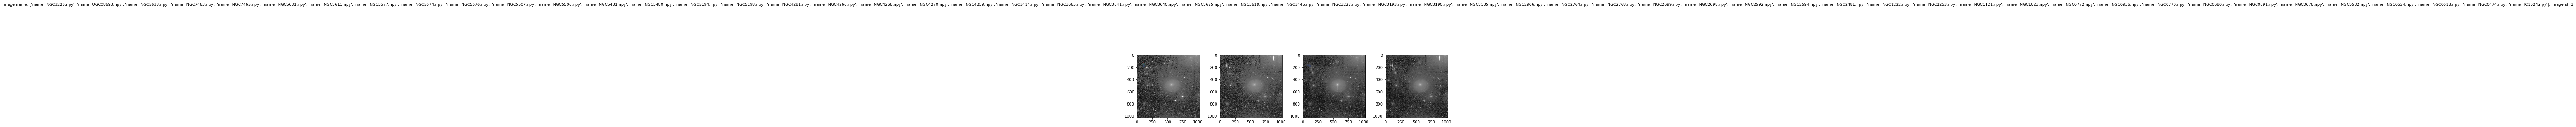

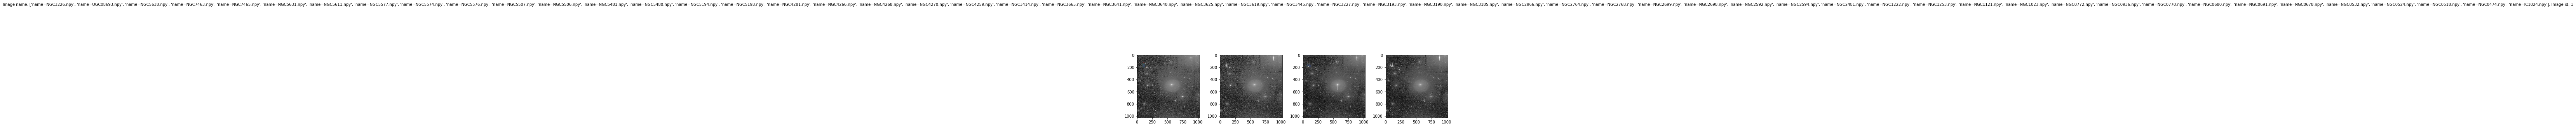

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

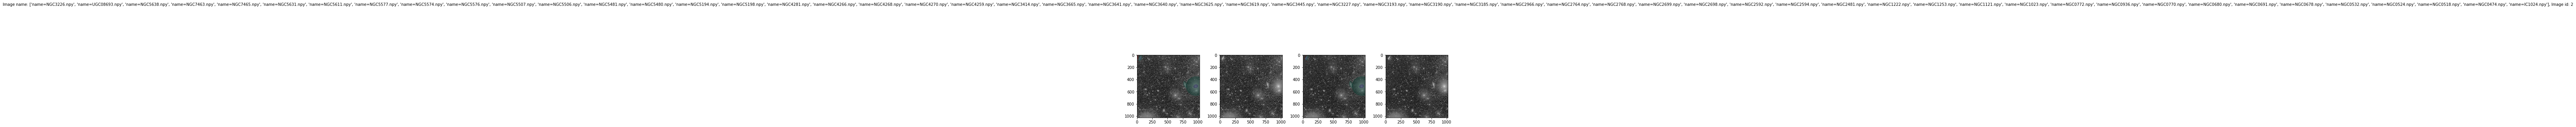

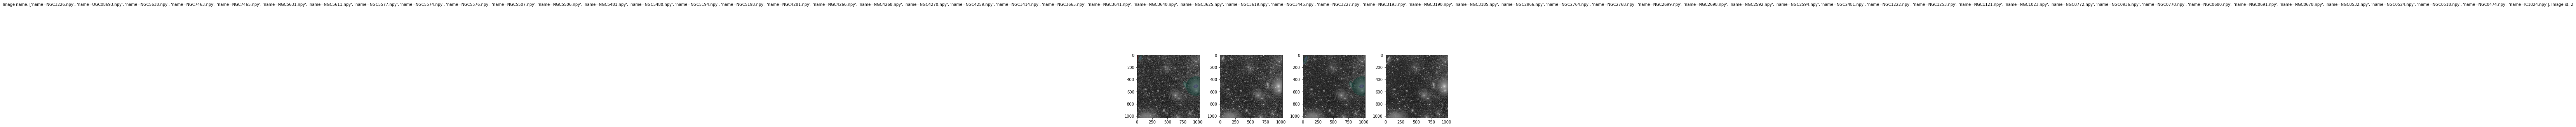

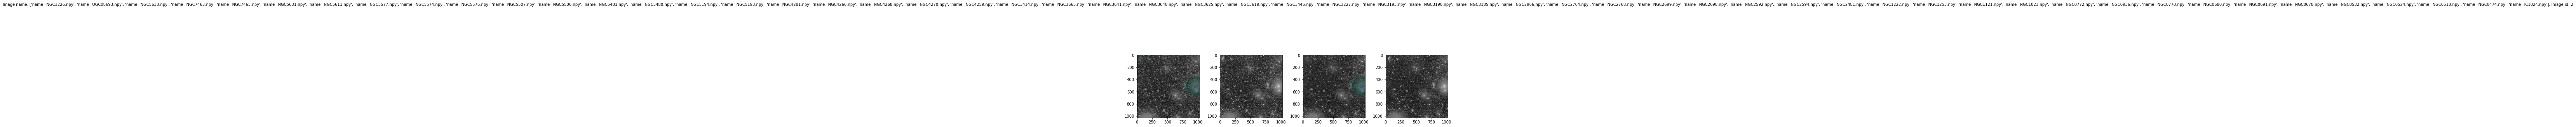

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

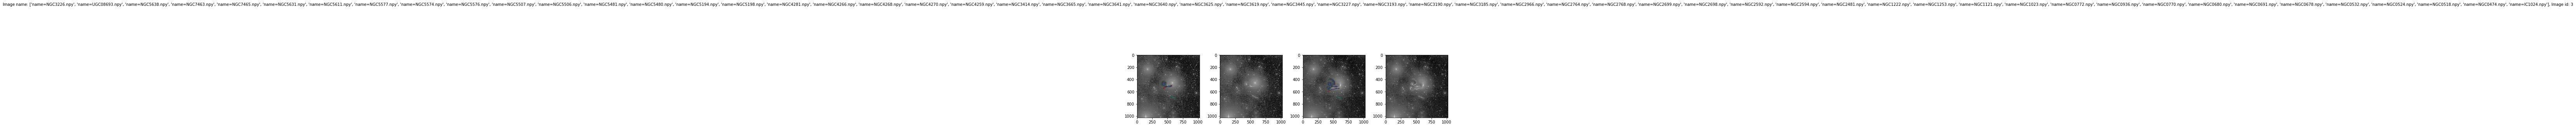

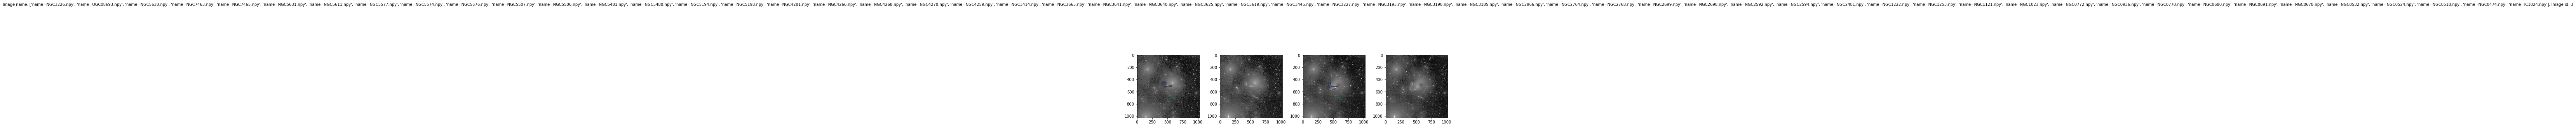

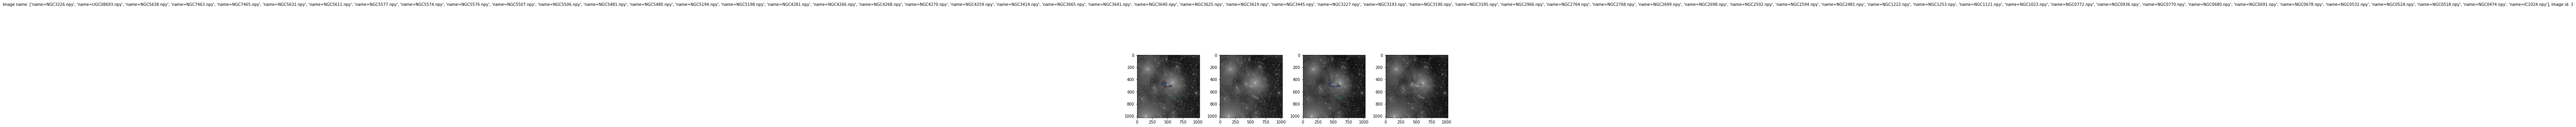

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

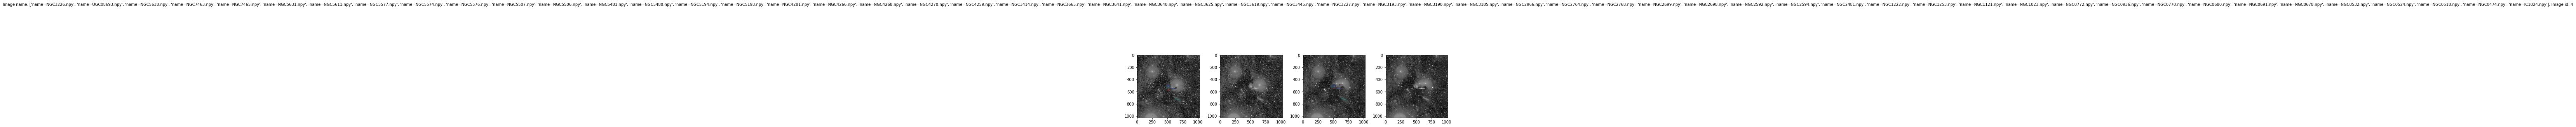

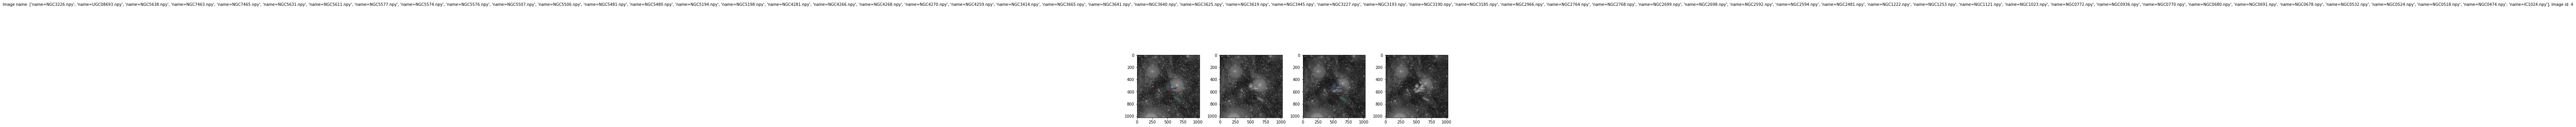

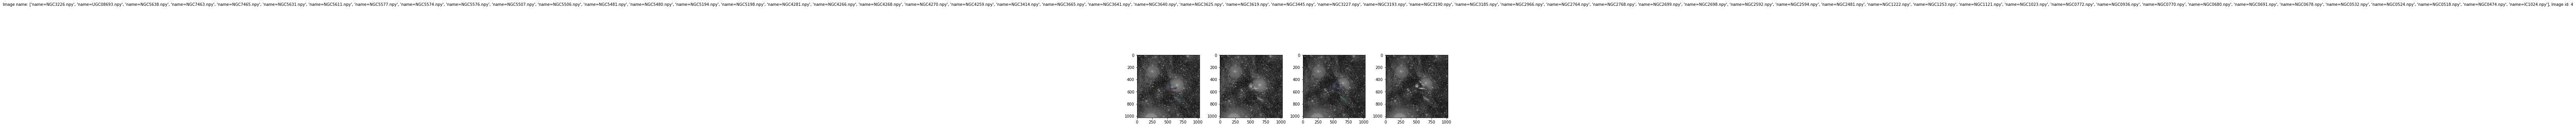

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

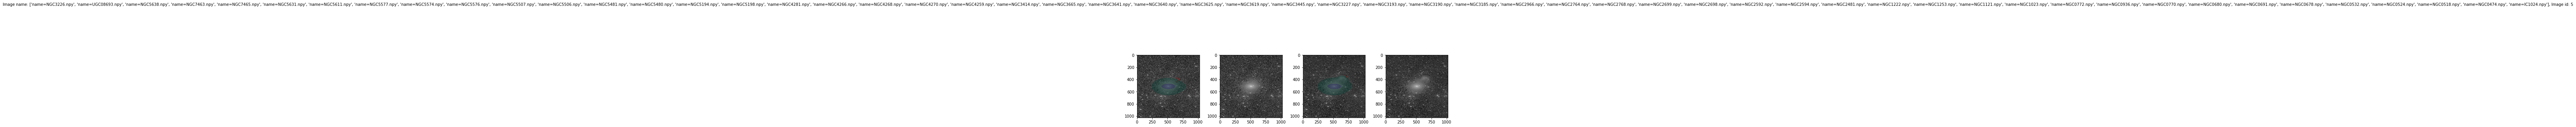

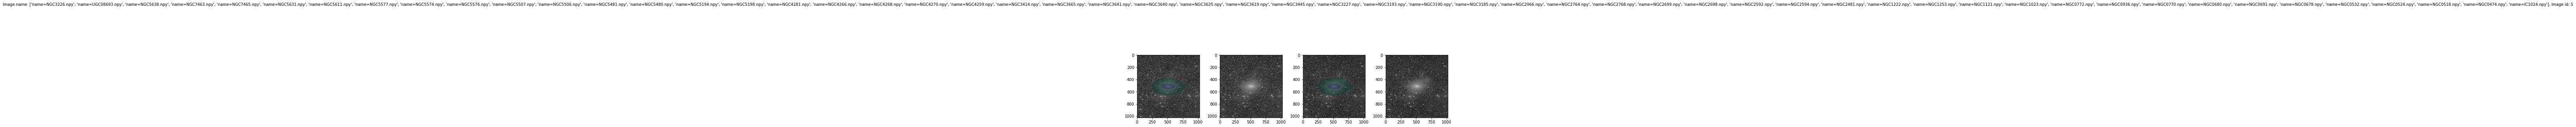

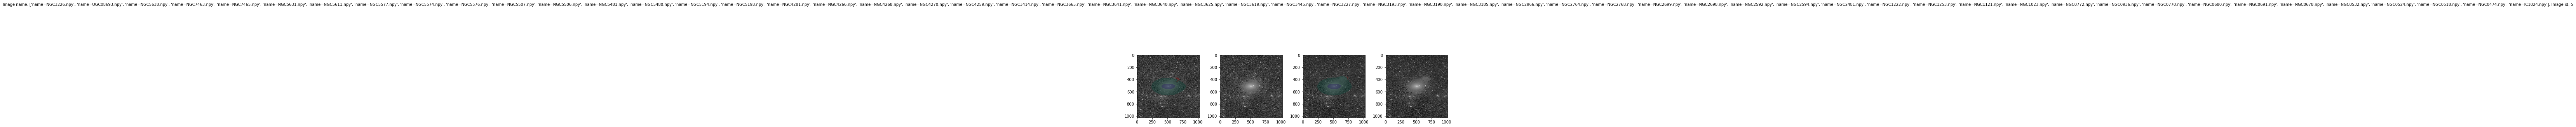

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

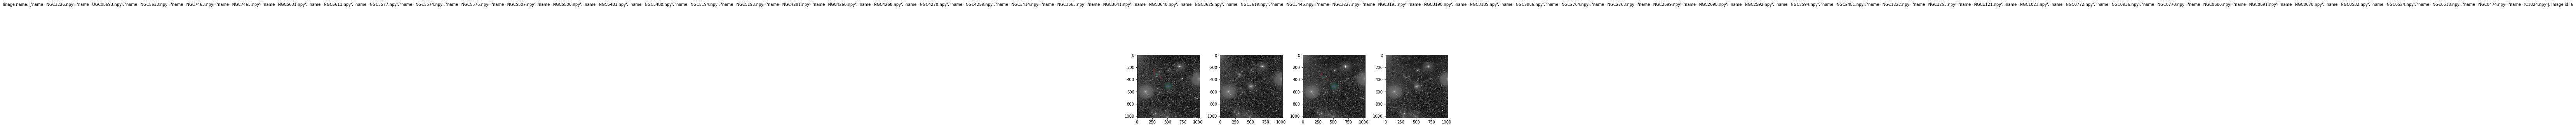

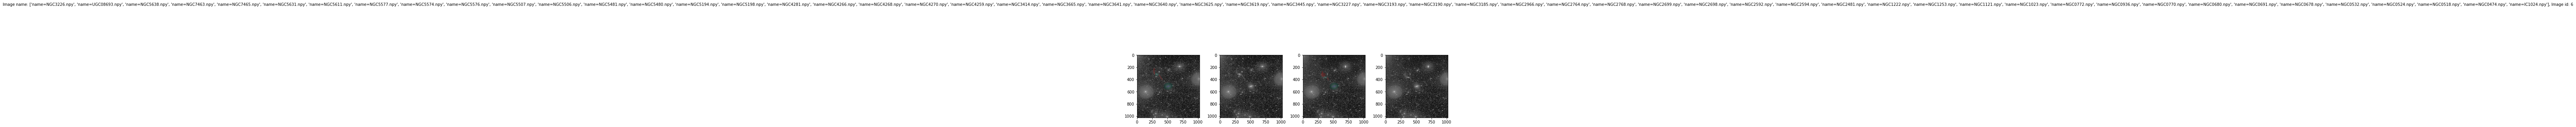

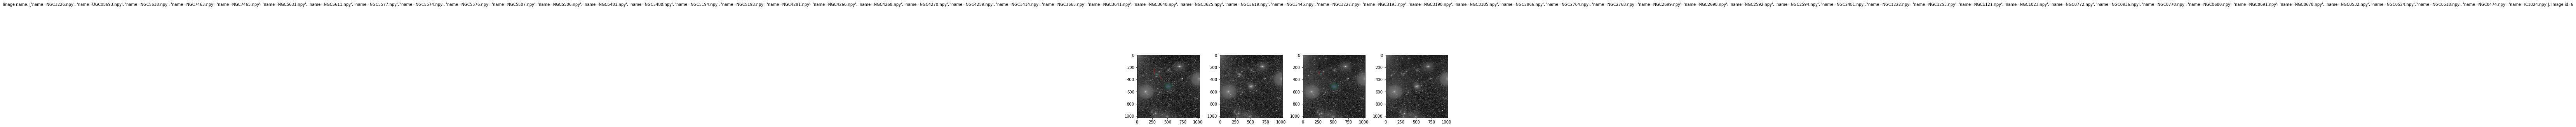

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

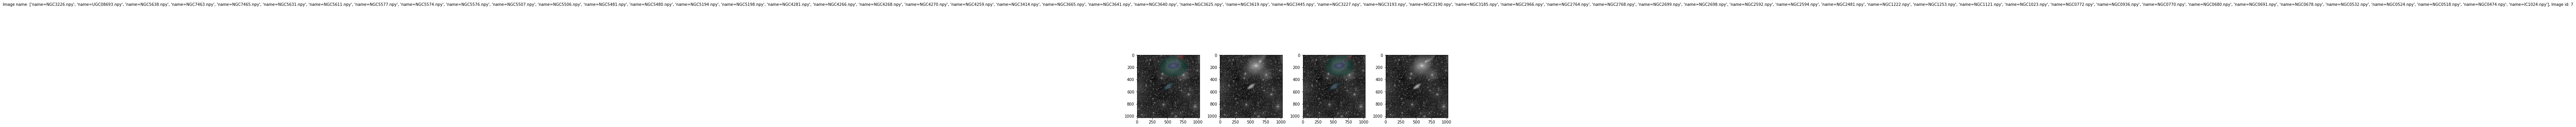

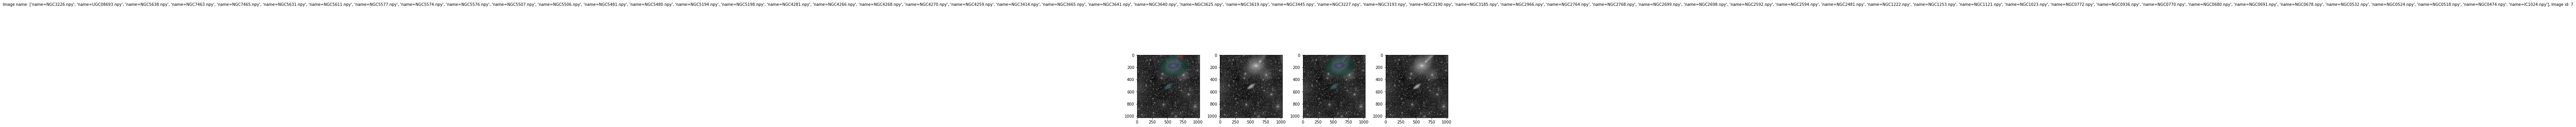

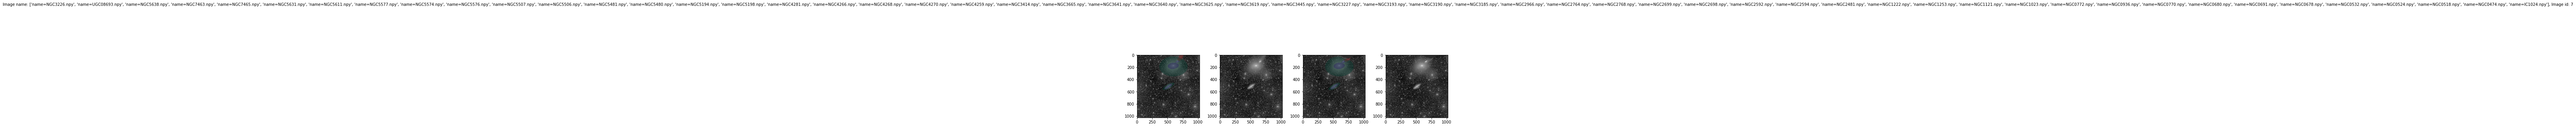

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

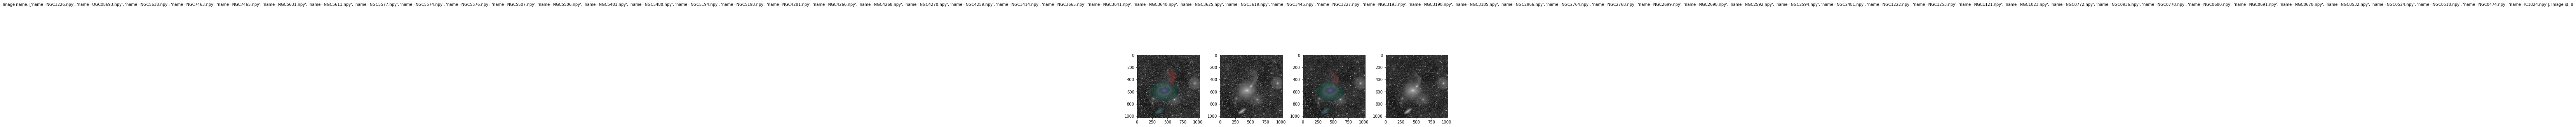

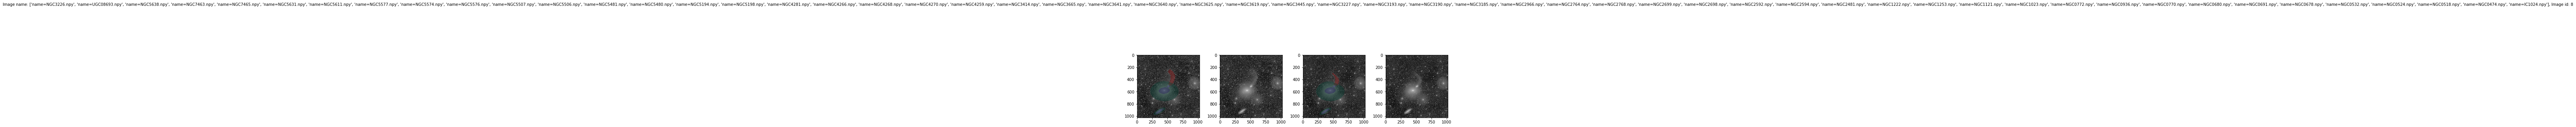

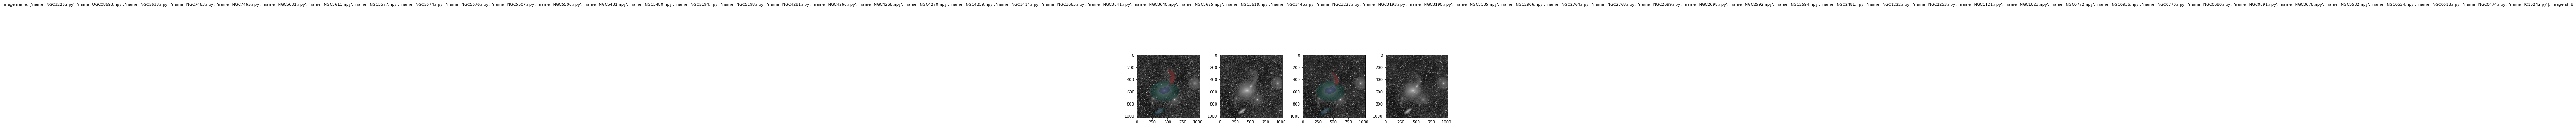

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

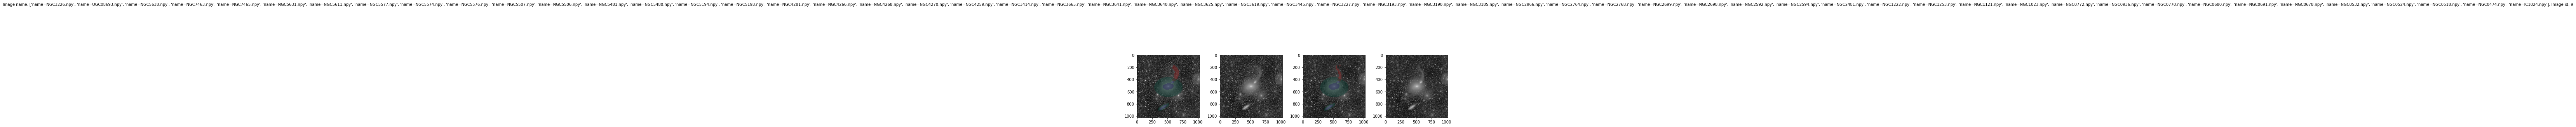

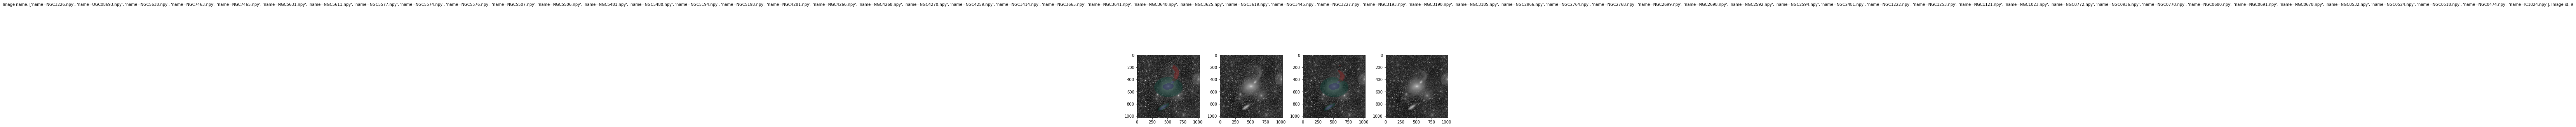

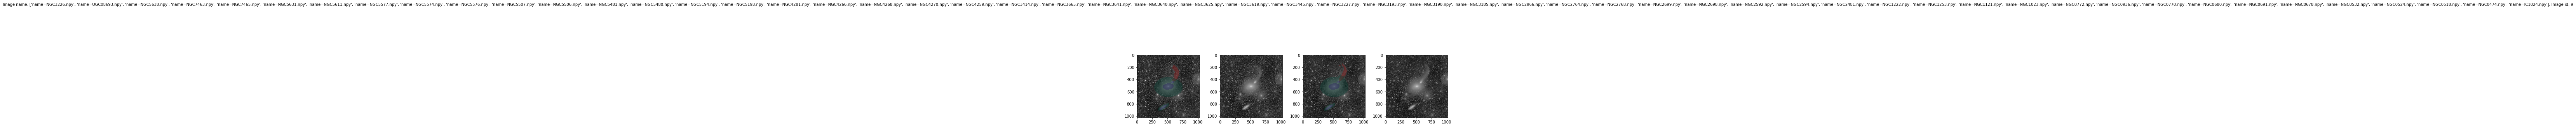

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

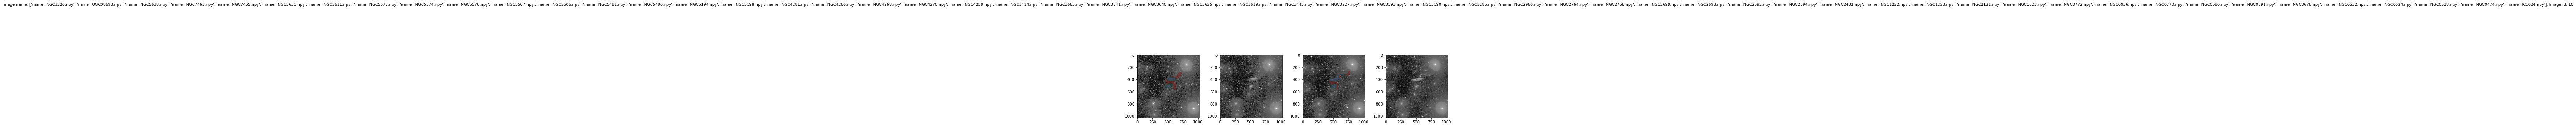

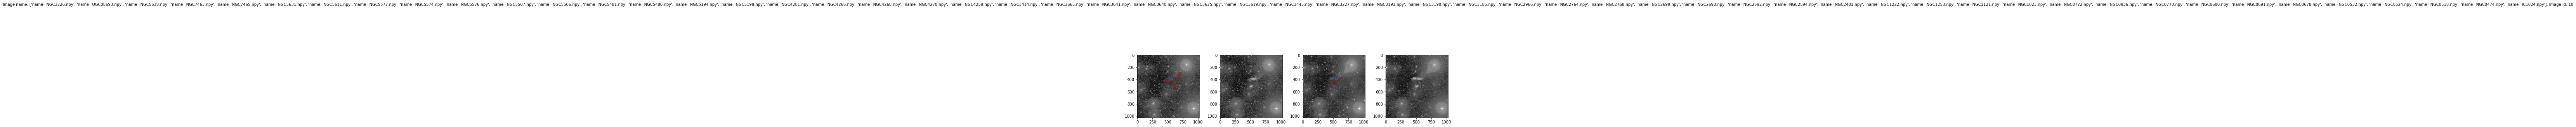

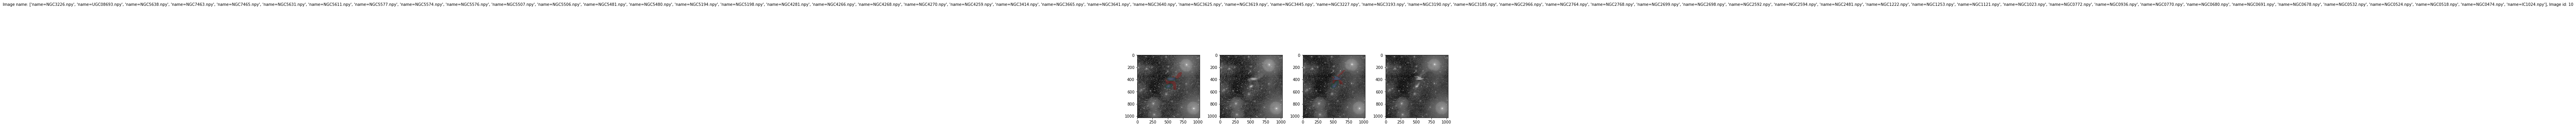

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

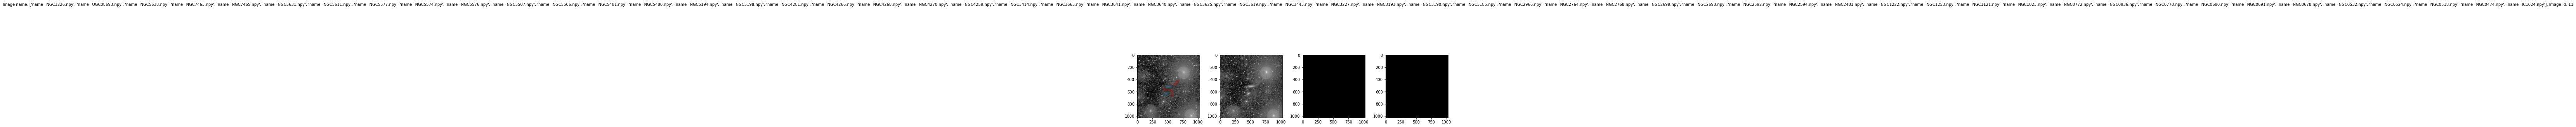

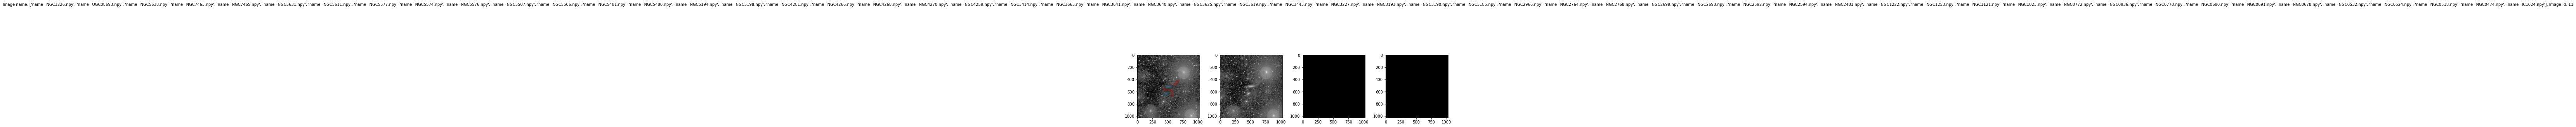

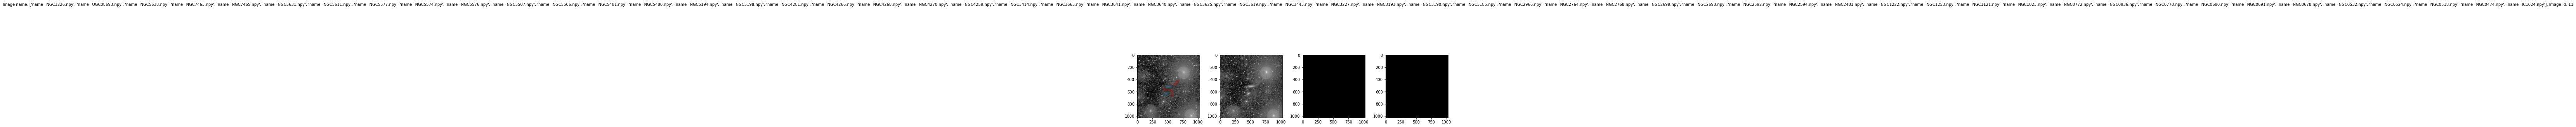

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

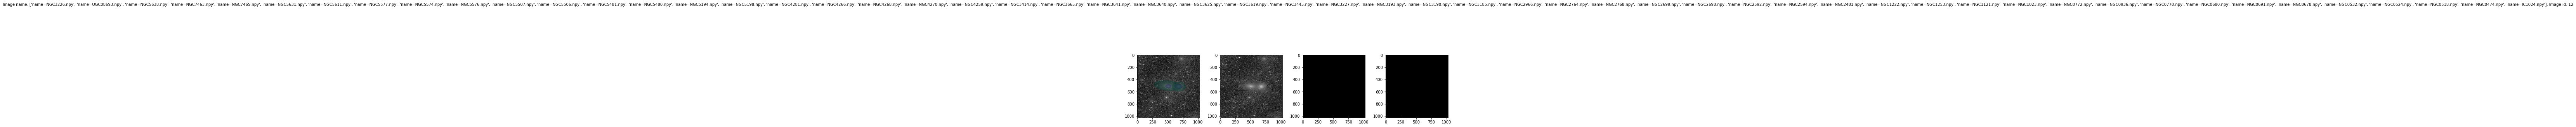

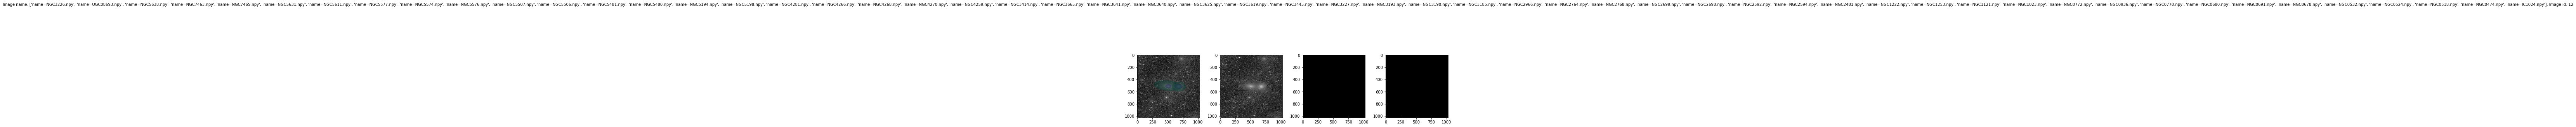

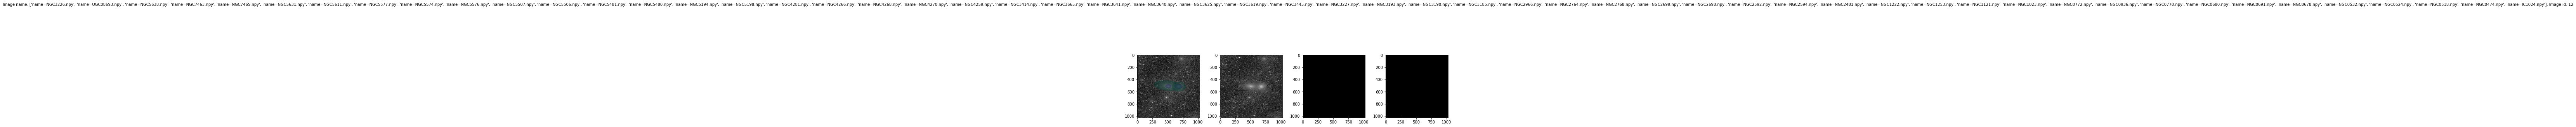

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

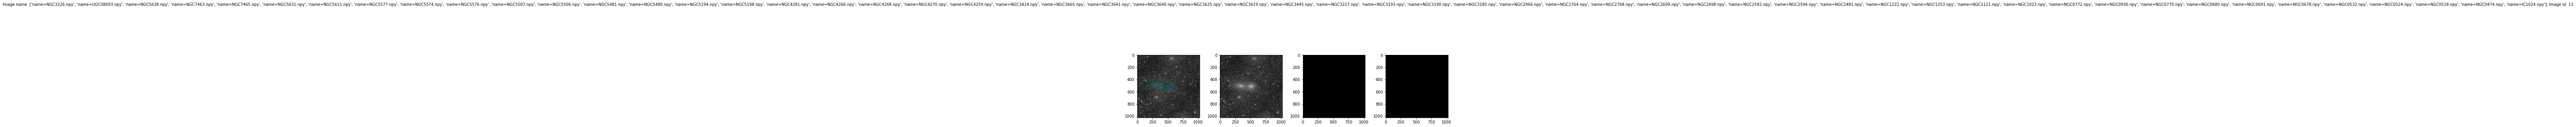

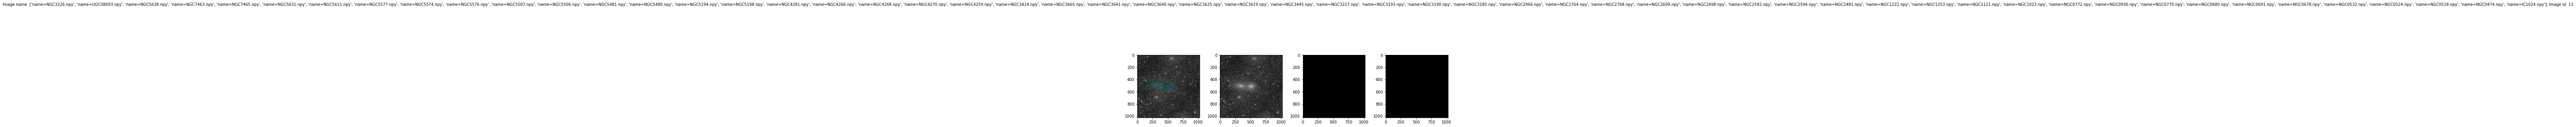

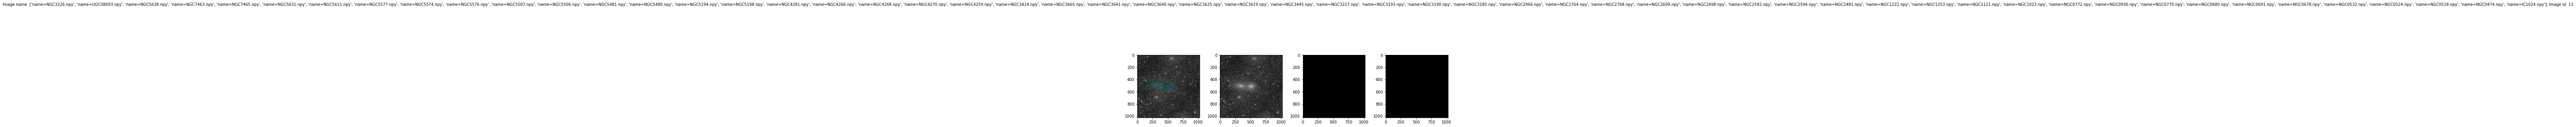

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

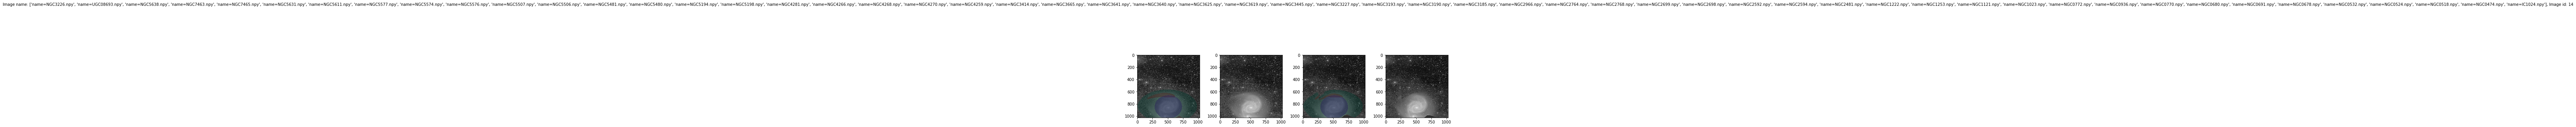

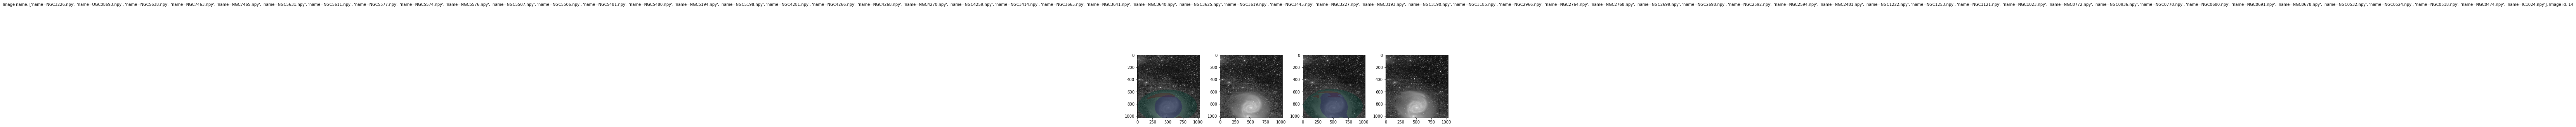

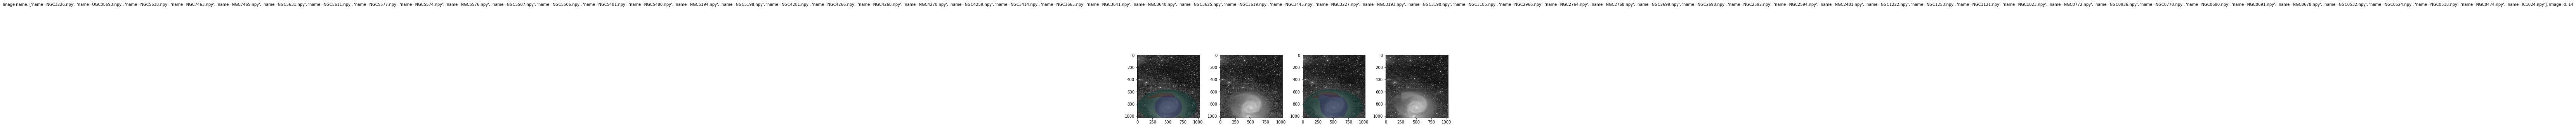

['name=NGC3226.npy', 'name=UGC08693.npy', 'name=NGC5638.npy', 'name=NGC7463.npy', 'name=NGC7465.npy', 'name=NGC5631.npy', 'name=NGC5611.npy', 'name=NGC5577.npy', 'name=NGC5574.npy', 'name=NGC5576.npy', 'name=NGC5507.npy', 'name=NGC5506.npy', 'name=NGC5481.npy', 'name=NGC5480.npy', 'name=NGC5194.npy', 'name=NGC5198.npy', 'name=NGC4281.npy', 'name=NGC4266.npy', 'name=NGC4268.npy', 'name=NGC4270.npy', 'name=NGC4259.npy', 'name=NGC3414.npy', 'name=NGC3665.npy', 'name=NGC3641.npy', 'name=NGC3640.npy', 'name=NGC3625.npy', 'name=NGC3619.npy', 'name=NGC3445.npy', 'name=NGC3227.npy', 'name=NGC3193.npy', 'name=NGC3190.npy', 'name=NGC3185.npy', 'name=NGC2966.npy', 'name=NGC2764.npy', 'name=NGC2768.npy', 'name=NGC2699.npy', 'name=NGC2698.npy', 'name=NGC2592.npy', 'name=NGC2594.npy', 'name=NGC2481.npy', 'name=NGC1222.npy', 'name=NGC1253.npy', 'name=NGC1121.npy', 'name=NGC1023.npy', 'name=NGC0772.npy', 'name=NGC0936.npy', 'name=NGC0770.npy', 'name=NGC0680.npy', 'name=NGC0691.npy', 'name=NGC0678.npy'

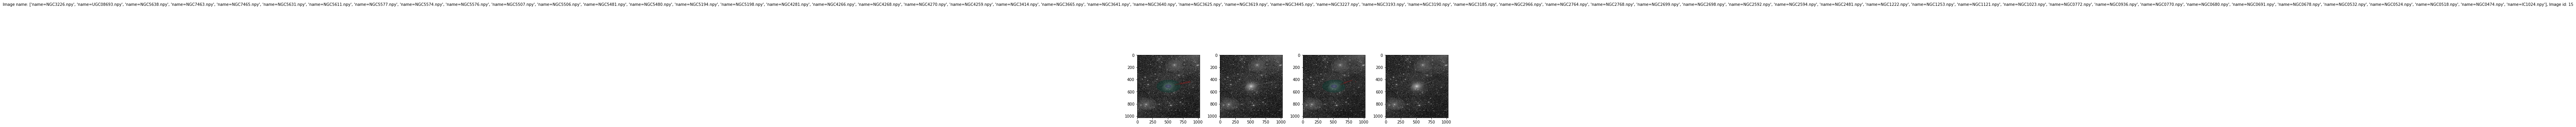

In [19]:
%matplotlib inline
import random

COLOR_LIST = ['jet', 'Purples', 'BrBG', 'BuGn', 'GnBu']

# SAVE_IMAGE_PATH = "../datasets/matlas_images_and_annotations/images/"
# SAVE_ANNOTATION_PATH = "../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions_augsplittidal/"
SAVE_IMAGE_PATH = "./"
SAVE_ANNOTATION_PATH = "./basichalosnocompanions_augsplittidal/"


map_x = None
map_y = None

for idx in range(len(mask_files_name["Elongated tidal structures"])):
    # change the path of the images
    data = np.load(file_path + "_images/" + image_files_name[idx])
    print(image_files_name)
    masks = {}
    masks["Elongated tidal structures"] = getMask(mask_files_name["Elongated tidal structures"][idx])

    obj_list = ["Galaxy", "Diffuse halo", "Ghosted halo"]

    for obj_type in obj_list:
        try:
            masks[obj_type] = getMask(mask_files_name[obj_type][idx])
        except:
            pass

    # generate 3 augmented images per 1 original image

    for dummy_idx in range(3):
        fig = plt.figure(figsize=(12,12))
        
        fig.suptitle('Image name: {}, Image id: {}'.format(image_files_name, idx), fontsize=10)

        ax0 = fig.add_subplot(1, 4, 1)
        ax0.imshow(data[0,:,:], "gray" , interpolation='none')
        for j, obj_type in enumerate(["Elongated tidal structures"] + obj_list):
            if obj_type in masks:
                for i in range(masks[obj_type].shape[0]):
                    ax0.imshow(masks[obj_type][i,:,:], COLOR_LIST[j], interpolation='none', alpha=0.4*(masks[obj_type][i,:,:]>0))

        ax1 = fig.add_subplot(1, 4, 2)
        ax1.imshow(data[0,:,:], "gray" , interpolation='none')

        augmented_data, augmented_masks, map_x, map_y = elongDeform(data, masks)
        
        ax2 = fig.add_subplot(1, 4, 3)
        ax2.imshow(augmented_data[0,:,:], "gray" , interpolation='none')
        # plt.imshow(augmented_masks["Elongated tidal structures"][0,:,:], COLOR_LIST[0], interpolation='none', alpha=0.4*(augmented_masks["Elongated tidal structures"][0,:,:]>0))
        for j, obj_type in enumerate(["Elongated tidal structures"] + obj_list):
            if obj_type in augmented_masks:
                for i in range(augmented_masks[obj_type].shape[0]):
                    ax2.imshow(augmented_masks[obj_type][i,:,:], COLOR_LIST[j], interpolation='none', alpha=0.4*(augmented_masks[obj_type][i,:,:]>0))

                [dummy_mask_file_name, dummy_mask_structure] = os.path.split(mask_files_name[obj_type][idx])[-1].split("-")
                encode_np_mask( augmented_masks[obj_type], SAVE_ANNOTATION_PATH + dummy_mask_file_name + 'D' + str(dummy_idx) + '-' + dummy_mask_structure)
        
        ax3 = fig.add_subplot(1, 4, 4)
        ax3.imshow(augmented_data[0,:,:], "gray" , interpolation='none')


        fig.tight_layout() 
        fig.subplots_adjust(hspace=0.05, bottom=0.5)

        plt.show()